In [ ]:
pip install sbi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.0/460.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 842.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
  

In [ ]:
#!pip install numba==0.59.0

import numpy as np
import torch

from sbi.inference import NPE
from sbi.utils import BoxUniform
# ----------------------------
# STEP 1: Load train/test, normalize X, transform theta -> (logT0, gamma)
# ----------------------------

# 0) File paths (edit these)
TRAIN_PATH = "lyalpha_train_z2.50_grid5x5_Nsims100000_R80_SNRlogU20.npz"
TEST_PATH  = "lyalpha_test_z2.50_grid5x5_Nsims25000_R20_SNRlogU20.npz"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# 1) Load
train_data = np.load(TRAIN_PATH, allow_pickle=True)
test_data  = np.load(TEST_PATH, allow_pickle=True)

X_train_np = train_data["X"].astype(np.float32)         # (N_train, Npix)
theta_train_np = train_data["theta"].astype(np.float32) # (N_train, 2) = [T0, gamma] in your saved files

X_test_np = test_data["X"].astype(np.float32)           # (N_test, Npix)
theta_test_np = test_data["theta"].astype(np.float32)   # (N_test, 2)

N_train, Npix = X_train_np.shape
N_test,  Npix2 = X_test_np.shape
assert Npix == Npix2, "Npix mismatch between train and test."
print(f"Loaded: N_train={N_train}, N_test={N_test}, Npix={Npix}")


# 2) Sanity checks
assert X_train_np.ndim == 2 and theta_train_np.ndim == 2 and theta_train_np.shape[1] == 2
assert X_test_np.ndim == 2 and theta_test_np.ndim == 2 and theta_test_np.shape[1] == 2
assert X_train_np.shape[1] == X_test_np.shape[1], "Npix mismatch between train and test."
assert X_train_np.shape[0] == theta_train_np.shape[0], "Train X/theta length mismatch."
assert X_test_np.shape[0] == theta_test_np.shape[0], "Test X/theta length mismatch."

print("Raw theta ranges (as stored):",
      f"T0 in [{theta_train_np[:,0].min():.1f}, {theta_train_np[:,0].max():.1f}]",
      f"gamma in [{theta_train_np[:,1].min():.3f}, {theta_train_np[:,1].max():.3f}]")

# 3) Normalize X using TRAIN statistics (apply same to test)
# For tau spectra: just standardize each pixel feature across the training set.
x_mean = X_train_np.mean(axis=0, keepdims=True).astype(np.float32)  # (1, Npix)
x_std  = X_train_np.std(axis=0, keepdims=True).astype(np.float32)   # (1, Npix)
x_std  = np.clip(x_std, 1e-6, None)

X_train_np = ((X_train_np - x_mean) / x_std).astype(np.float32)
X_test_np  = ((X_test_np  - x_mean) / x_std).astype(np.float32)

print("Post-normalization checks:")
print("  X_train mean (approx):", float(X_train_np.mean()))
print("  X_train std  (approx):", float(X_train_np.std()))
print("  Any NaNs in X_train?", np.isnan(X_train_np).any())


print("Post-normalization checks:")
print("  X_train mean (approx):", float(X_train_np.mean()))
print("  X_train std  (approx):", float(X_train_np.std()))
print("  Any NaNs in X_train?", np.isnan(X_train_np).any())

# 4) Transform theta: [T0, gamma] -> [logT0, gamma]
#    (natural log)
theta_train_np_t = np.column_stack([np.log(theta_train_np[:, 0]), theta_train_np[:, 1]]).astype(np.float32)
theta_test_np_t  = np.column_stack([np.log(theta_test_np[:, 0]),  theta_test_np[:, 1]]).astype(np.float32)

print("Transformed theta ranges:",
      f"logT0 in [{theta_train_np_t[:,0].min():.3f}, {theta_train_np_t[:,0].max():.3f}]",
      f"gamma in [{theta_train_np_t[:,1].min():.3f}, {theta_train_np_t[:,1].max():.3f}]")

# 5) Convert to torch tensors
x_train = torch.from_numpy(X_train_np).to(DEVICE)
theta_train = torch.from_numpy(theta_train_np_t).to(DEVICE)

x_test = torch.from_numpy(X_test_np).to(DEVICE)
theta_test = torch.from_numpy(theta_test_np_t).to(DEVICE)

print("Torch tensors:", x_train.shape, theta_train.shape, x_test.shape, theta_test.shape)

# Keep normalization stats for later inference on real observed spectra
# (store these somewhere safe, or keep in memory in the notebook)
X_NORM = {
    "mean": x_mean,  # shape (1, Npix)
    "std":  x_std,   # shape (1, Npix)
    "Npix": int(Npix),
}

Using device: cpu
Loaded: N_train=100000, N_test=25000, Npix=100
Raw theta ranges (as stored): T0 in [8000.0, 18000.0] gamma in [1.200, 1.700]
Post-normalization checks:
  X_train mean (approx): 1.4442748863530142e-07
  X_train std  (approx): 1.000006079673767
  Any NaNs in X_train? False
Post-normalization checks:
  X_train mean (approx): 1.4442748863530142e-07
  X_train std  (approx): 1.000006079673767
  Any NaNs in X_train? False
Transformed theta ranges: logT0 in [8.987, 9.798] gamma in [1.200, 1.700]
Torch tensors: torch.Size([100000, 100]) torch.Size([100000, 2]) torch.Size([25000, 100]) torch.Size([25000, 2])


In [ ]:
# ----------------------------
# STEP 2: Define a grid-mixture prior in (logT0, gamma)
# ----------------------------

# 1) Read the grid from the training file metadata (preferred, because it's exact)
meta = train_data["meta"][0]   # you stored meta=np.array([meta], dtype=object)

T0_grid_np = np.asarray(meta["T0_grid_K"], dtype=np.float32)      # shape (5,)
gamma_grid_np = np.asarray(meta["gamma_grid"], dtype=np.float32)  # shape (5,)

T0_grid = torch.tensor(T0_grid_np, device=DEVICE, dtype=torch.float32)
gamma_grid = torch.tensor(gamma_grid_np, device=DEVICE, dtype=torch.float32)

# Transform T0 grid to log-space since our theta is (logT0, gamma)
logT0_grid = torch.log(T0_grid)  # natural log

# 2) Build the 25 centers (logT0, gamma) in a fixed order
#    centers will be shape (25, 2)
logT0_centers = logT0_grid.repeat_interleave(gamma_grid.numel())  # (25,)
gamma_centers = gamma_grid.repeat(logT0_grid.numel())             # (25,)
centers = torch.stack([logT0_centers, gamma_centers], dim=1)      # (25, 2)

# 3) Set Gaussian smoothing widths as a small fraction of grid spacing
#    Grid spacing in each dimension (constant for your construction)
dlogT0 = (logT0_grid[1] - logT0_grid[0]).abs()
dgamma = (gamma_grid[1] - gamma_grid[0]).abs()

SMOOTH_FRACTION = 0.15  # 10–20% is typical; must be << 1 to keep peaks separated

sigma_logT0 = SMOOTH_FRACTION * dlogT0
sigma_gamma = SMOOTH_FRACTION * dgamma

# Each component is 2D Normal with diagonal covariance (sigma_logT0^2, sigma_gamma^2)
scales = torch.stack([sigma_logT0, sigma_gamma]).to(DEVICE)  # (2,)
scales = scales.expand(centers.shape[0], 2)                  # (25, 2)

# 4) Create a uniform categorical over the 25 components
mix = torch.distributions.Categorical(
    probs=torch.ones(centers.shape[0], device=DEVICE) / centers.shape[0]
)

# 5) Component distribution: Normal(loc=centers, scale=scales), treated as 2D event
components = torch.distributions.Independent(
    torch.distributions.Normal(loc=centers, scale=scales),
    1
)

# 6) Mixture prior p(theta) in the transformed space theta=(logT0, gamma)
prior = torch.distributions.MixtureSameFamily(mix, components)

print("Prior defined as MixtureSameFamily over centers (logT0, gamma).")
print("Centers shape:", centers.shape)
print("Per-dimension sigmas:", float(sigma_logT0), float(sigma_gamma))

Prior defined as MixtureSameFamily over centers (logT0, gamma).
Centers shape: torch.Size([25, 2])
Per-dimension sigmas: 0.030409814789891243 0.01875000074505806


In [ ]:
PREFERRED_DENSITY_ESTIMATOR = "zuko_nsf"  # try first
FALLBACK_DENSITY_ESTIMATOR  = "nsf"       # fallback (nflows/pyknos)

# IMPORTANT:
# - theta_train / theta_test are in transformed space: [logT0, gamma]
# - prior is also defined in the same transformed space
# - x_train / x_test are optical depth vectors

try:
    inference = NPE(prior=prior, density_estimator=PREFERRED_DENSITY_ESTIMATOR, device=DEVICE)
    print(f"Using density_estimator='{PREFERRED_DENSITY_ESTIMATOR}' on device='{DEVICE}'")
except Exception as e:
    print(f"Could not use '{PREFERRED_DENSITY_ESTIMATOR}' (reason: {e})")
    inference = NPE(prior=prior, density_estimator=FALLBACK_DENSITY_ESTIMATOR, device=DEVICE)
    print(f"Falling back to density_estimator='{FALLBACK_DENSITY_ESTIMATOR}' on device='{DEVICE}'")

Using density_estimator='zuko_nsf' on device='cpu'


In [ ]:
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding

num_dims = x_train.shape[1]  # Npix

# FCEmbedding signature: FCEmbedding(input_dim, output_dim=20, num_layers=2, num_hiddens=50)
embedding = FCEmbedding(input_dim=num_dims,
                            output_dim=64,
                            num_layers=3,
                            num_hiddens=128,)

# If you already normalized your tau vectors, avoid sbi's internal z-scoring:
density_estimator_builder = posterior_nn(
    model="maf",
    embedding_net=embedding,
    z_score_x="none",
    z_score_theta="none"
)

inference = NPE(prior=prior, density_estimator=density_estimator_builder, device=DEVICE)


In [ ]:
# ----------------------------
# STEP 4: Append simulations, train q_phi(theta|x), then build posterior
# ----------------------------

# 1) Train the conditional density estimator on (theta_train, x_train)
#    theta_train: (N_train, 2) = [logT0, gamma]
#    x_train    : (N_train, Npix) normalized flux vectors
density_estimator = inference.append_simulations(theta_train, x_train).train(
    training_batch_size=256,
    learning_rate=3e-4,
    validation_fraction=0.1,
    stop_after_epochs=30,
    max_num_epochs=10_000,
    clip_max_norm=5.0,
    show_train_summary=True,
    force_first_round_loss=True,   # safe even for single-round; helps some sbi versions
)

# 2) Build posterior wrapper
#    IMPORTANT: pass density_estimator explicitly to avoid "posterior is None" issues
posterior = inference.build_posterior(density_estimator)

# 3) (Optional but recommended) Set a default x so sampling works cleanly
#    This also helps sbi cache shapes and avoids accidental CPU/GPU mismatches later.
posterior = posterior.set_default_x(x_train[0])

print("Training done. Posterior ready.")
print("density_estimator type:", type(density_estimator))
print("posterior type:", type(posterior))


 Neural network successfully converged after 106 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 106
        Best validation performance: -1.3203
        -------------------------
        
Training done. Posterior ready.
density_estimator type: <class 'sbi.neural_nets.estimators.nflows_flow.NFlowsFlow'>
posterior type: <class 'sbi.inference.posteriors.direct_posterior.DirectPosterior'>


In [ ]:

# ----------------------------
# STEP 5: Evaluation + sanity checks (for theta = [logT0, gamma])
# ----------------------------

# ---- Config ----
SAMPLES_PER_X = 4000
N_EVAL = min(200, x_test.shape[0])
CI_LEVELS = [0.50, 0.68, 0.90, 0.95]
EVAL_SEED = 123

# ----------------------------
# A) Clean sanity checks
# ----------------------------
def _assert_finite_torch(name, t):
    assert torch.is_tensor(t), f"{name} is not a torch.Tensor"
    assert t.dtype == torch.float32, f"{name} dtype is {t.dtype}, expected float32"
    assert torch.isfinite(t).all().item(), f"{name} has NaN/Inf"

def _assert_finite_np(name, a):
    assert isinstance(a, np.ndarray), f"{name} is not a numpy array"
    assert np.isfinite(a).all(), f"{name} has NaN/Inf"

assert posterior is not None, "posterior is None (build_posterior failed)"
assert x_train.ndim == 2 and theta_train.ndim == 2 and theta_train.shape[1] == 2
assert x_test.ndim == 2 and theta_test.ndim == 2 and theta_test.shape[1] == 2
assert x_train.shape[1] == x_test.shape[1], "Npix mismatch between train/test"
assert x_train.shape[0] == theta_train.shape[0], "train X/theta length mismatch"
assert x_test.shape[0] == theta_test.shape[0], "test X/theta length mismatch"

_assert_finite_torch("x_train", x_train)
_assert_finite_torch("theta_train", theta_train)
_assert_finite_torch("x_test", x_test)
_assert_finite_torch("theta_test", theta_test)

# Sanity: X normalization should be roughly mean~0, std~1 across dataset (not exact, but close)
# We'll check global mean/std on a subset to keep it cheap
with torch.no_grad():
    Xsub = x_train[: min(2000, x_train.shape[0])].detach().float()
    m = Xsub.mean().item()
    s = Xsub.std().item()
print(f"[sanity] x_train global mean≈{m:.3f}, std≈{s:.3f} (should be ~0, ~1)")

# Sanity: theta ranges in transformed space
theta_train_np = theta_train.detach().cpu().numpy()
logT0_min, logT0_max = theta_train_np[:, 0].min(), theta_train_np[:, 0].max()
gamma_min, gamma_max = theta_train_np[:, 1].min(), theta_train_np[:, 1].max()
print(f"[sanity] theta_train ranges: logT0 in [{logT0_min:.3f}, {logT0_max:.3f}], gamma in [{gamma_min:.3f}, {gamma_max:.3f}]")

# Optional: verify logT0 corresponds to T0 in [5000, 20000]
print(f"[sanity] exp(logT0) range: T0 in [{np.exp(logT0_min):.1f}, {np.exp(logT0_max):.1f}] K")

# ----------------------------
# B) Build grid centers (for grid-aware evaluation)
# ----------------------------
# Use meta from train_data (exact grid)
meta = train_data["meta"][0]
T0_grid_np = np.asarray(meta["T0_grid_K"], dtype=np.float32)      # (5,)
gamma_grid_np = np.asarray(meta["gamma_grid"], dtype=np.float32)  # (5,)

T0_grid = torch.tensor(T0_grid_np, device=DEVICE, dtype=torch.float32)
gamma_grid = torch.tensor(gamma_grid_np, device=DEVICE, dtype=torch.float32)
logT0_grid = torch.log(T0_grid)

logT0_centers = logT0_grid.repeat_interleave(gamma_grid.numel())  # (25,)
gamma_centers = gamma_grid.repeat(logT0_grid.numel())             # (25,)
centers = torch.stack([logT0_centers, gamma_centers], dim=1)      # (25,2) on DEVICE

# Helpers to map theta -> nearest center index (true class) and posterior samples -> predicted class
def nearest_center_index(theta_2, centers_25x2):
    # theta_2: (2,) torch, centers: (25,2)
    d2 = ((centers_25x2 - theta_2[None, :]) ** 2).sum(dim=1)  # (25,)
    return int(torch.argmin(d2).item())

def predicted_center_index_from_samples(samples_Sx2, centers_25x2):
    # samples: (S,2)
    # nearest center for each sample
    diff = samples_Sx2[:, None, :] - centers_25x2[None, :, :]      # (S,25,2)
    d2 = (diff ** 2).sum(dim=2)                                    # (S,25)
    nn = torch.argmin(d2, dim=1)                                   # (S,)
    # mode of nearest-center assignments
    counts = torch.bincount(nn, minlength=centers_25x2.shape[0])
    return int(torch.argmax(counts).item())

# ----------------------------
# C) Sampling-based metrics + calibration
# ----------------------------
post_means = np.zeros((N_EVAL, 2), dtype=np.float32)   # mean in (logT0, gamma)
post_stds  = np.zeros((N_EVAL, 2), dtype=np.float32)

coverage_counts = {lvl: np.zeros(2, dtype=np.int32) for lvl in CI_LEVELS}

# Optional T0-space point estimate + error (Kelvin)
# We'll use E[T0] estimated from samples, not exp(E[logT0]).
post_T0_meanK = np.zeros((N_EVAL,), dtype=np.float32)
true_T0_K     = np.zeros((N_EVAL,), dtype=np.float32)

# Grid-aware accuracy
true_class = np.zeros((N_EVAL,), dtype=np.int32)
pred_class = np.zeros((N_EVAL,), dtype=np.int32)

# Reproducible sampling
torch.manual_seed(EVAL_SEED)

posterior = posterior.set_default_x(x_test[0])  # ensures internal shape/device are set

for i in range(N_EVAL):
    x_i = x_test[i]              # (Npix,)
    theta_true_t = theta_test[i] # (2,) = [logT0, gamma]

    # Draw posterior samples in transformed space
    with torch.no_grad():
        samples = posterior.sample((SAMPLES_PER_X,), x=x_i)  # (S,2) on DEVICE
        # basic sanity
        assert torch.isfinite(samples).all().item(), "posterior samples contain NaN/Inf"

    samples_np = samples.detach().cpu().numpy()
    theta_true_np = theta_true_t.detach().cpu().numpy()

    # Posterior mean/std in transformed space
    mu = samples_np.mean(axis=0)
    sd = samples_np.std(axis=0)
    post_means[i] = mu.astype(np.float32)
    post_stds[i]  = sd.astype(np.float32)

    # T0-space diagnostics (Kelvin)
    T0_samples = np.exp(samples_np[:, 0])
    post_T0_meanK[i] = np.float32(T0_samples.mean())
    true_T0_K[i] = np.float32(np.exp(theta_true_np[0]))

    # Marginal CI coverage in transformed space
    for lvl in CI_LEVELS:
        alpha = 1.0 - lvl
        lo = np.quantile(samples_np, alpha / 2, axis=0)
        hi = np.quantile(samples_np, 1.0 - alpha / 2, axis=0)
        inside = (theta_true_np >= lo) & (theta_true_np <= hi)
        coverage_counts[lvl] += inside.astype(np.int32)

    # Grid-aware classification (mode of nearest-center assignments)
    with torch.no_grad():
        t_idx = nearest_center_index(theta_true_t, centers)
        p_idx = predicted_center_index_from_samples(samples, centers)

    true_class[i] = t_idx
    pred_class[i] = p_idx

    if (i + 1) % 50 == 0 or (i + 1) == N_EVAL:
        print(f"[eval] {i+1}/{N_EVAL}")

[sanity] x_train global mean≈-0.075, std≈0.981 (should be ~0, ~1)
[sanity] theta_train ranges: logT0 in [8.987, 9.798], gamma in [1.200, 1.700]
[sanity] exp(logT0) range: T0 in [8000.0, 18000.0] K


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[eval] 50/200


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[eval] 100/200


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[eval] 150/200


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

[eval] 200/200


In [ ]:
# ----------------------------
# D) Summary metrics
# ----------------------------
theta_true_eval = theta_test[:N_EVAL].detach().cpu().numpy()

# Point-estimate error in transformed space using posterior mean
rmse = np.sqrt(np.mean((post_means - theta_true_eval) ** 2, axis=0))
mae  = np.mean(np.abs(post_means - theta_true_eval), axis=0)

print("\nPoint-estimate error (posterior mean) in transformed space:")
print(f"  logT0 RMSE: {rmse[0]:.6f}   MAE: {mae[0]:.6f}")
print(f"  gamma RMSE: {rmse[1]:.6f}   MAE: {mae[1]:.6f}")

# Optional: T0-space error (Kelvin) using E[T0] from samples
rmse_T0 = np.sqrt(np.mean((post_T0_meanK - true_T0_K) ** 2))
mae_T0  = np.mean(np.abs(post_T0_meanK - true_T0_K))
print("\nT0-space point-estimate error (E[T0] from posterior samples):")
print(f"  T0   RMSE: {rmse_T0:.2f} K   MAE: {mae_T0:.2f} K")

print("\nMarginal credible-interval coverage in transformed space:")
for lvl in CI_LEVELS:
    cov = coverage_counts[lvl] / float(N_EVAL)
    print(f"  {int(lvl*100)}% CI:  logT0={cov[0]:.3f}, gamma={cov[1]:.3f}")

# Grid-aware accuracy
nT0 = int(len(T0_grid_np))
nG  = int(len(gamma_grid_np))
assert nT0 * nG == centers.shape[0]

acc = (pred_class == true_class).mean()
t0_acc = ((pred_class // nG) == (true_class // nG)).mean()   # T0 index accuracy
g_acc  = ((pred_class %  nG) == (true_class %  nG)).mean()   # gamma index accuracy    # gamma index accuracy

print("\nGrid-aware accuracy (mode of nearest-center assignments):")
print(f"  Exact (T0_idx AND gamma_idx correct): {acc:.3f}")
print(f"  T0 index accuracy: {t0_acc:.3f}")
print(f"  gamma index accuracy: {g_acc:.3f}")



Point-estimate error (posterior mean) in transformed space:
  logT0 RMSE: 0.315224   MAE: 0.300710
  gamma RMSE: 0.157996   MAE: 0.131295

T0-space point-estimate error (E[T0] from posterior samples):
  T0   RMSE: 3501.71 K   MAE: 3303.86 K

Marginal credible-interval coverage in transformed space:
  50% CI:  logT0=0.020, gamma=0.520
  68% CI:  logT0=0.395, gamma=0.680
  90% CI:  logT0=0.880, gamma=0.825
  95% CI:  logT0=0.935, gamma=0.985

Grid-aware accuracy (mode of nearest-center assignments):
  Exact (T0_idx AND gamma_idx correct): 0.000
  T0 index accuracy: 0.510
  gamma index accuracy: 0.150


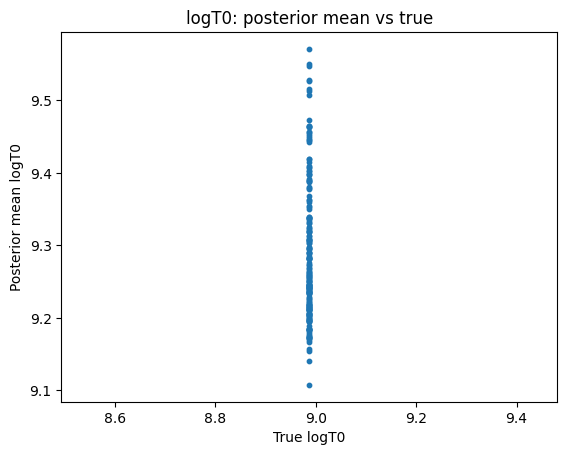

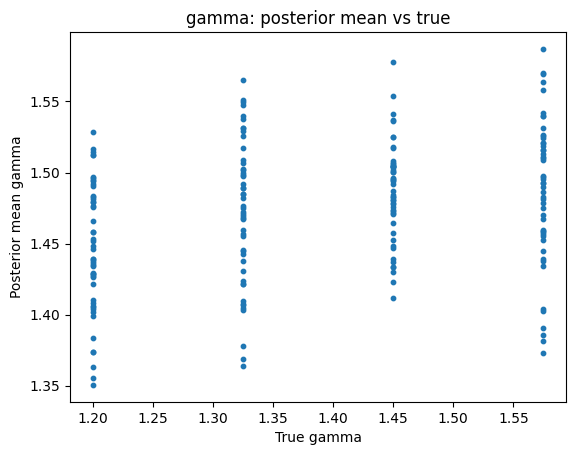

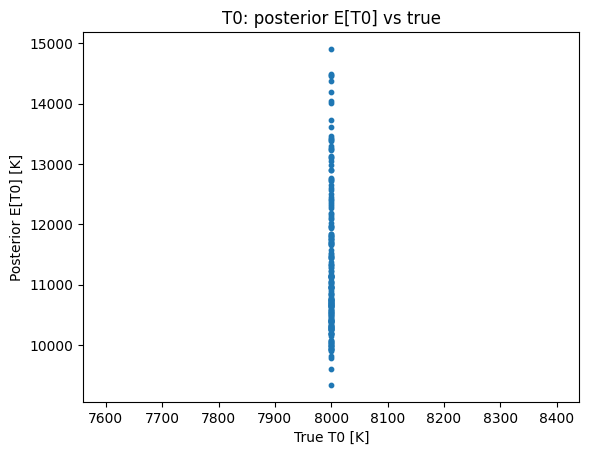

In [ ]:
#----------------------------
# E) Plots: posterior mean vs true (transformed space) + T0-space
# ----------------------------
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(theta_true_eval[:, 0], post_means[:, 0], s=10)
plt.xlabel("True logT0")
plt.ylabel("Posterior mean logT0")
plt.title("logT0: posterior mean vs true")
plt.show()

plt.figure()
plt.scatter(theta_true_eval[:, 1], post_means[:, 1], s=10)
plt.xlabel("True gamma")
plt.ylabel("Posterior mean gamma")
plt.title("gamma: posterior mean vs true")
plt.show()

plt.figure()
plt.scatter(true_T0_K, post_T0_meanK, s=10)
plt.xlabel("True T0 [K]")
plt.ylabel("Posterior E[T0] [K]")
plt.title("T0: posterior E[T0] vs true")
plt.show()

  0%|          | 0/40000 [00:00<?, ?it/s]


Example index 9294: true logT0=9.3927, true T0=12000.0 K, true gamma=1.2000


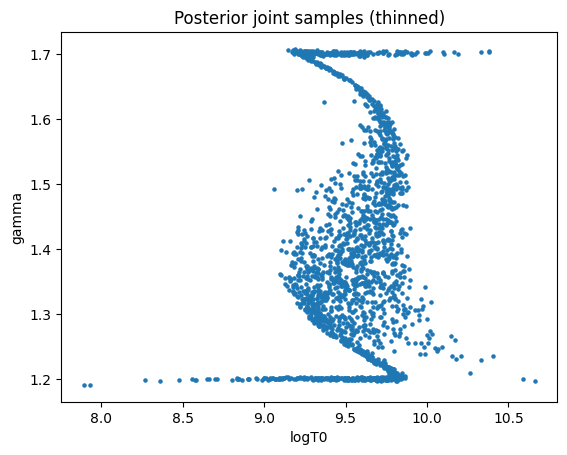

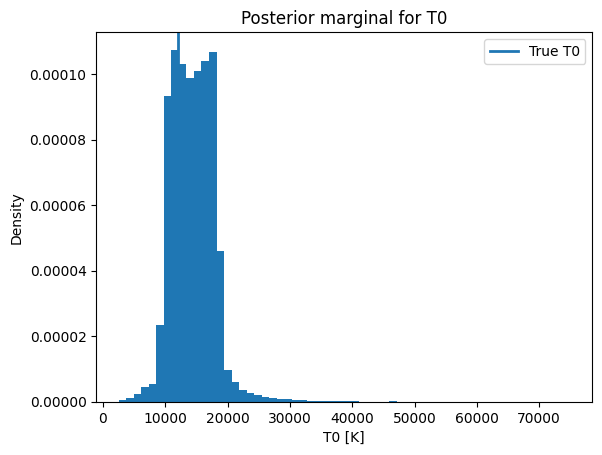

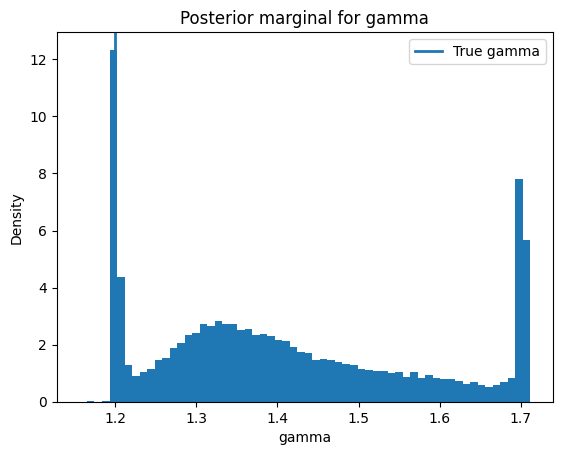

In [ ]:
# ----------------------------
# F) One random test example: show joint samples + marginals
# ---------------------------
EVAL_SEED = 5884
rng = np.random.default_rng(EVAL_SEED)
j = int(rng.integers(0, x_test.shape[0]))

x_o = x_test[j]
theta_o = theta_test[j].detach().cpu().numpy()
T0_true_o = float(np.exp(theta_o[0]))

with torch.no_grad():
    S = 40000
    samp_o = posterior.sample((S,), x=x_o).detach().cpu().numpy()

logT0_s = samp_o[:, 0]
gamma_s = samp_o[:, 1]
T0_s = np.exp(logT0_s)

print(f"\nExample index {j}: true logT0={theta_o[0]:.4f}, true T0={T0_true_o:.1f} K, true gamma={theta_o[1]:.4f}")

plt.figure()
plt.scatter(logT0_s[::20], gamma_s[::20], s=5)  # thin for speed/clarity
plt.xlabel("logT0")
plt.ylabel("gamma")
plt.title("Posterior joint samples (thinned)")
plt.show()

plt.figure()
plt.hist(T0_s, bins=60, density=True)
plt.axvline(T0_true_o, linewidth=2, label="True T0")
plt.xlabel("T0 [K]")
plt.ylabel("Density")
plt.title("Posterior marginal for T0")
plt.legend()
plt.show()

plt.figure()
plt.hist(gamma_s, bins=60, density=True)
plt.axvline(theta_o[1], linewidth=2, label="True gamma")
plt.xlabel("gamma")
plt.ylabel("Density")
plt.title("Posterior marginal for gamma")
plt.legend()
plt.show()

In [ ]:
!pip install corner

  0%|          | 0/4000 [00:00<?, ?it/s]


1D central credible intervals (transformed space):
  logT0 68% CI: [9.0484, 9.6170], median=9.3312
  logT0 95% CI: [8.8340, 9.8345], median=9.3312
  gamma 68% CI: [1.2221, 1.6447], median=1.4438
  gamma 95% CI: [1.1992, 1.7042], median=1.4438

1D central credible intervals for T0 (Kelvin):
  T0 68% CI: [8504.8, 15017.6] K, median=11284.9 K
  T0 95% CI: [6863.4, 18666.0] K, median=11284.9 K


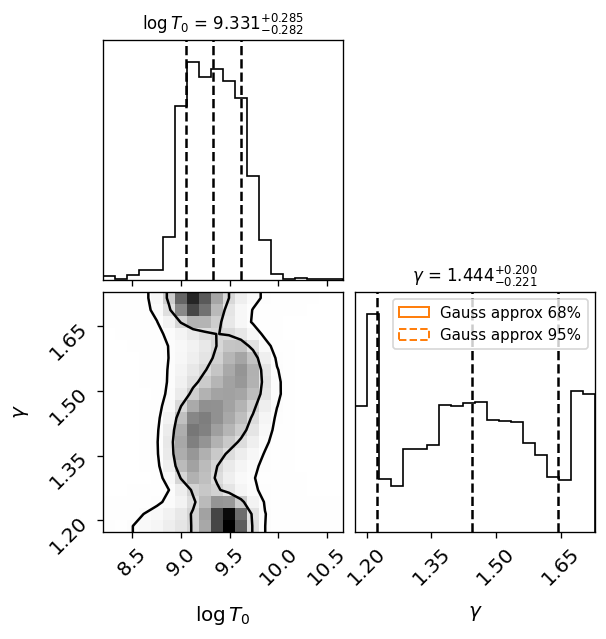

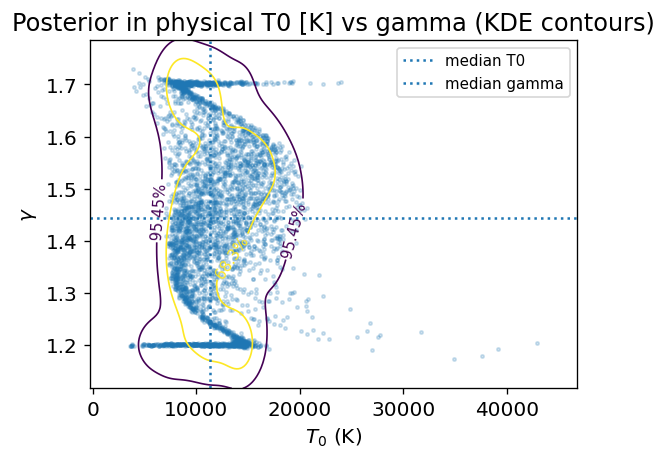

In [ ]:
# --------- Posterior plotting utilities (paste after your training/evaluation code) ----------
import numpy as np
import torch
import matplotlib.pyplot as plt
import corner

# Optional nice plotting
plt.rcParams.update({"figure.dpi": 120, "font.size": 12})

# Try imports, suggest install if missing
#try:
#    import corner
#except Exception as e:
#    !pip install corner
#    raise ImportError("corner not found. Install with: pip install corner") from e

try:
    from scipy.stats import gaussian_kde, chi2
except Exception as e:
    raise ImportError("scipy not found. Install with: pip install scipy") from e

from matplotlib.patches import Ellipse

# ----------------- Helper functions -----------------
def sample_posterior_numpy(posterior_obj, x_input, n_samples=4000, seed=None, device=None):
    """
    Draw samples from sbi posterior and return numpy array (n_samples, 2).
    x_input: torch tensor or numpy array of shape (Npix,) or (1, Npix).
    device: optional device string (e.g., 'cpu' or 'cuda'); if None uses posterior defaults.
    """
    # Prepare x as torch on correct device
    if isinstance(x_input, np.ndarray):
        x_t = torch.from_numpy(x_input.astype(np.float32))
    else:
        x_t = x_input.clone()
    # If shape is (Npix,), make it (Npix,)
    if x_t.ndim == 2 and x_t.shape[0] == 1:
        x_t = x_t.squeeze(0)
    if seed is not None:
        torch.manual_seed(seed)
    with torch.no_grad():
        samples_t = posterior_obj.sample((n_samples,), x=x_t)
    # ensure float32 on cpu
    samples_np = samples_t.detach().cpu().numpy().astype(np.float64)
    return samples_np

def gaussian_ellipse_params(samples_np, prob=0.6827):
    """
    Compute ellipse parameters (width, height, angle) for a Gaussian approx
    that encloses probability 'prob' for 2D (df=2). Returns (width, height, angle_degrees, mean).
    'width' and 'height' are the full axes lengths (2 * sqrt(eigvals * chi2_val)).
    """
    # 1) mean & covariance
    mu = samples_np.mean(axis=0)
    cov = np.cov(samples_np.T, bias=False)  # 2x2
    # 2) eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)  # ascending eigvals
    # sort descending
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # 3) chi2 critical value for df=2
    chi2_val = chi2.ppf(prob, df=2)
    # axis lengths (full) = 2 * sqrt(eigval * chi2_val)
    axis_lengths = 2.0 * np.sqrt(eigvals * chi2_val)
    # angle (degrees) from x-axis
    vx, vy = eigvecs[:, 0]  # principal eigenvector
    angle = np.degrees(np.arctan2(vy, vx))
    width, height = axis_lengths[0], axis_lengths[1]
    return width, height, angle, mu, cov

def credible_intervals_1d(samples_1d, probs=(0.6827, 0.9545)):
    """
    Return central credible intervals for each prob in probs.
    Returns dict: prob -> (lo, median, hi)
    """
    res = {}
    for p in probs:
        alpha = 1.0 - p
        lo = np.quantile(samples_1d, alpha / 2.0)
        med = np.quantile(samples_1d, 0.5)
        hi = np.quantile(samples_1d, 1.0 - alpha / 2.0)
        res[p] = (lo, med, hi)
    return res

def kde_contour_levels_2d(samples_np, grid_res=200, probs=(0.6827, 0.9545)):
    """
    Compute KDE on a grid and return contour levels (density thresholds) for each prob.
    samples_np: (N,2)
    Returns: xx, yy, density grid (2D), levels list corresponding to probs.
    """
    kde = gaussian_kde(samples_np.T)
    x_min, x_max = samples_np[:,0].min(), samples_np[:,0].max()
    y_min, y_max = samples_np[:,1].min(), samples_np[:,1].max()
    # expand bounds slightly for nice plotting
    x_pad = 0.1 * (x_max - x_min) if x_max > x_min else 0.1
    y_pad = 0.1 * (y_max - y_min) if y_max > y_min else 0.1
    xs = np.linspace(x_min - x_pad, x_max + x_pad, grid_res)
    ys = np.linspace(y_min - y_pad, y_max + y_pad, grid_res)
    xx, yy = np.meshgrid(xs, ys)
    grid_coords = np.vstack([xx.ravel(), yy.ravel()])
    dens = kde(grid_coords).reshape(xx.shape)

    # To find density thresholds that enclose a given probability mass:
    # sort density values descending, compute cumulative sum * area per pixel, find cutoff
    # Normalize so integral of density over grid ≈ 1 (it will be because gaussian_kde integrates to 1)
    flat = dens.ravel()
    idx = np.argsort(flat)[::-1]          # descending
    sorted_d = flat[idx]
    cumsum = np.cumsum(sorted_d)
    cumsum /= cumsum[-1]                  # normalized cumulative
    levels = []
    for p in probs:
        # find density threshold where cumulative >= p
        try:
            cutoff_idx = np.searchsorted(cumsum, p)
            cutoff = sorted_d[cutoff_idx]
        except Exception:
            cutoff = sorted_d[-1]
        levels.append(cutoff)
    return xx, yy, dens, levels

# ----------------- Main plotting function -----------------
def plot_posterior_2d_with_intervals(posterior_obj, x_obs=None,
                                     n_samples=4000, seed=42,
                                     label_logT0=r"$\log T_0$",
                                     label_gamma=r"$\gamma$",
                                     show_T0_panel=True):
    """
    Make a corner-style plot for (logT0, gamma) showing 1D marginals and 2D contours.
    Also prints 1D credible intervals and optionally makes a T0[K] vs gamma KDE contour plot.
    """
    # 1) default x_obs
    if x_obs is None:
        # assume x_test exists in user namespace
        try:
            x_obs = x_test[0]
        except NameError:
            raise ValueError("x_obs is None and x_test is not found. Provide x_obs.")
    # 2) sample
    samples = sample_posterior_numpy(posterior_obj, x_obs, n_samples=n_samples, seed=seed)
    # samples shape (S,2) corresponding to [logT0, gamma]
    if samples.shape[1] != 2:
        raise ValueError("Posterior samples must be shape (S,2) corresponding to [logT0, gamma].")

    # 3) Corner plot (uses empirical samples for contours)
    fig = corner.corner(samples,
                        labels=[label_logT0, label_gamma],
                        quantiles=[0.16, 0.5, 0.84],            # 1D median & 1-sigma quantiles
                        show_titles=True,
                        title_fmt=".3f",
                        truths=None,
                        levels=(0.6827, 0.9545),               # draw contours that contain these fractions
                        smooth=1.0,
                        plot_datapoints=False,
                        fill_contours=False,
                        title_kwargs={"fontsize": 10})
    ax_xy = fig.axes[3]  # in corner ordering for 2 params: axes[3] is the 2D subplot
    # 4) Overlay Gaussian-approx ellipses for 1σ & 2σ (transformed space)
    for prob, color, ls in [(0.6827, "C1", "solid"), (0.9545, "C1", "dashed")]:
        w, h, angle, mu, cov = gaussian_ellipse_params(samples, prob=prob)
        ell = Ellipse(xy=mu, width=w, height=h, angle=angle, edgecolor=color,
                      facecolor="none", linestyle=ls, linewidth=1.2, zorder=5, label=f"Gauss approx {int(prob*100)}%")
        ax_xy.add_patch(ell)
    # add legend to the lower-left subplot for 2D
    ax_xy.legend(loc="upper right", fontsize=9)

    # 5) Print 1D credible intervals (transformed space)
    ci_1d = credible_intervals_1d(samples[:,0], probs=(0.6827, 0.9545))
    ci_1d_g = credible_intervals_1d(samples[:,1], probs=(0.6827, 0.9545))
    print("\n1D central credible intervals (transformed space):")
    for p in (0.6827, 0.9545):
        lo, med, hi = ci_1d[p]
        print(f"  logT0 {int(p*100)}% CI: [{lo:.4f}, {hi:.4f}], median={med:.4f}")
    for p in (0.6827, 0.9545):
        lo, med, hi = ci_1d_g[p]
        print(f"  gamma {int(p*100)}% CI: [{lo:.4f}, {hi:.4f}], median={med:.4f}")

    # 6) Also report intervals in T0[K] (physical), using transformed samples
    logT0_samples = samples[:,0]
    T0_samples_K = np.exp(logT0_samples)
    ci_T0 = credible_intervals_1d(T0_samples_K, probs=(0.6827, 0.9545))
    print("\n1D central credible intervals for T0 (Kelvin):")
    for p in (0.6827, 0.9545):
        lo, med, hi = ci_T0[p]
        print(f"  T0 {int(p*100)}% CI: [{lo:.1f}, {hi:.1f}] K, median={med:.1f} K")

    # 7) Optional: make a KDE-based contour in T0[K] vs gamma (non-linear transform)
    if show_T0_panel:
        xx, yy, dens, levels = kde_contour_levels_2d(np.column_stack([T0_samples_K, samples[:,1]]),
                                                    grid_res=250, probs=(0.6827, 0.9545))
        # contour plot
        fig2, ax2 = plt.subplots(figsize=(5,4))
        cs = ax2.contour(xx, yy, dens, levels=sorted(levels), linewidths=1.0)
        # label contours with enclosed prob
        ax2.clabel(cs, fmt={levels[0]: "68.3%", levels[1]: "95.45%"}, fontsize=9)
        ax2.scatter(np.exp(samples[:,0]), samples[:,1], s=4, alpha=0.2)
        ax2.set_xlabel(r"$T_0\ \mathrm{(K)}$")
        ax2.set_ylabel(r"$\gamma$")
        ax2.set_title("Posterior in physical T0 [K] vs gamma (KDE contours)")
        # overlay medians
        ax2.axvline(np.median(T0_samples_K), linestyle=":", label="median T0")
        ax2.axhline(np.median(samples[:,1]), linestyle=":", label="median gamma")
        ax2.legend(fontsize=9)
        plt.tight_layout()
        plt.show()

    plt.show()
    return samples  # return samples for further use

# ----------------- Example usage -----------------
# Draw plot for the first test spectrum (x_test[0]) and return samples
# If you'd like to plot for a different spectrum use: plot_posterior_2d_with_intervals(posterior, x_obs=x_test[i], ...)
posterior_samples = plot_posterior_2d_with_intervals(posterior, x_obs=x_test[0],
                                                     n_samples=4000, seed=132423,
                                                     label_logT0=r"$\log T_0$",
                                                     label_gamma=r"$\gamma$",
                                                     show_T0_panel=True)

# posterior_samples is an (S,2) numpy array of [logT0, gamma] samples from your posterior.


  0%|          | 0/4000 [00:00<?, ?it/s]


1D central credible intervals (transformed space):
logT0 68% CI: [9.0502, 9.6168], median=9.3279
logT0 95% CI: [8.8393, 9.8341], median=9.3279
gamma 68% CI: [1.2223, 1.6437], median=1.4417
gamma 95% CI: [1.1991, 1.7045], median=1.4417

1D central credible intervals for T0 (Kelvin):
T0 68% CI: [8519.9, 15014.7] K, median=11247.9 K
T0 95% CI: [6900.4, 18658.5] K, median=11247.9 K


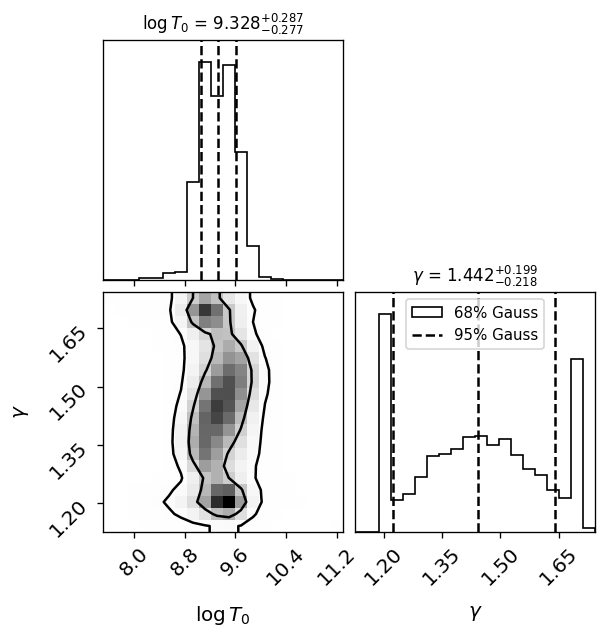

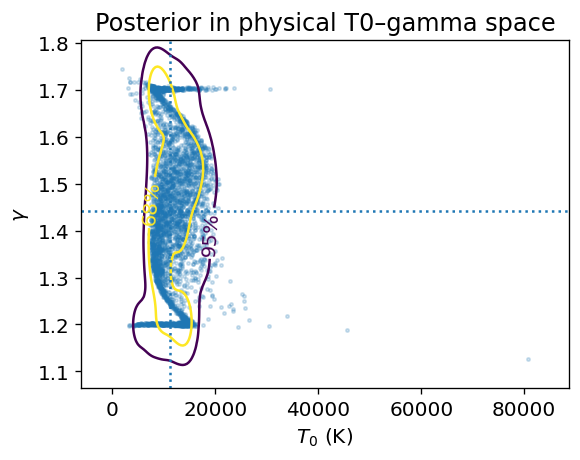

In [ ]:
# --------- Posterior plotting utilities ----------
import numpy as np
import torch
import matplotlib.pyplot as plt
import corner

from scipy.stats import gaussian_kde, chi2
from matplotlib.patches import Ellipse

plt.rcParams.update({"figure.dpi": 120, "font.size": 12})


# ----------------- Helper functions -----------------
def sample_posterior_numpy(posterior_obj, x_input, n_samples=4000, seed=None):
    if isinstance(x_input, np.ndarray):
        x_t = torch.from_numpy(x_input.astype(np.float32))
    else:
        x_t = x_input.clone()

    if seed is not None:
        torch.manual_seed(seed)

    with torch.no_grad():
        samples = posterior_obj.sample((n_samples,), x=x_t)

    return samples.detach().cpu().numpy().astype(np.float64)


def gaussian_ellipse_params(samples_np, prob=0.6827):
    mu = samples_np.mean(axis=0)
    cov = np.cov(samples_np.T)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    chi2_val = chi2.ppf(prob, df=2)
    axis_lengths = 2.0 * np.sqrt(eigvals * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))

    return axis_lengths[0], axis_lengths[1], angle, mu


def credible_intervals_1d(samples_1d, probs=(0.6827, 0.9545)):
    res = {}
    for p in probs:
        a = 1.0 - p
        lo = np.quantile(samples_1d, a / 2)
        med = np.quantile(samples_1d, 0.5)
        hi = np.quantile(samples_1d, 1.0 - a / 2)
        res[p] = (lo, med, hi)
    return res


def kde_contour_levels_2d(samples_np, grid_res=200, probs=(0.6827, 0.9545)):
    kde = gaussian_kde(samples_np.T)

    x_min, x_max = samples_np[:, 0].min(), samples_np[:, 0].max()
    y_min, y_max = samples_np[:, 1].min(), samples_np[:, 1].max()

    x_pad = 0.1 * (x_max - x_min)
    y_pad = 0.1 * (y_max - y_min)

    xs = np.linspace(x_min - x_pad, x_max + x_pad, grid_res)
    ys = np.linspace(y_min - y_pad, y_max + y_pad, grid_res)
    xx, yy = np.meshgrid(xs, ys)

    dens = kde(np.vstack([xx.ravel(), yy.ravel()])).reshape(xx.shape)

    flat = dens.ravel()
    idx = np.argsort(flat)[::-1]
    sorted_d = flat[idx]
    cumsum = np.cumsum(sorted_d)
    cumsum /= cumsum[-1]

    levels = [sorted_d[np.searchsorted(cumsum, p)] for p in probs]
    return xx, yy, dens, levels


# ----------------- Main plotting function -----------------
def plot_posterior_2d_with_intervals(
    posterior_obj,
    x_obs,
    n_samples=4000,
    seed=42,
    label_logT0=r"$\log T_0$",
    label_gamma=r"$\gamma$",
    show_T0_panel=True,
):

    samples = sample_posterior_numpy(posterior_obj, x_obs, n_samples, seed)

    # Corner plot in (logT0, gamma)
    fig = corner.corner(
        samples,
        labels=[label_logT0, label_gamma],
        quantiles=[0.16, 0.5, 0.84],
        levels=(0.6827, 0.9545),
        show_titles=True,
        title_fmt=".3f",
        smooth=1.0,
        plot_datapoints=False,
        fill_contours=False,
        title_kwargs={"fontsize": 10},
    )

    ax_xy = fig.axes[3]

    for prob, ls in [(0.6827, "solid"), (0.9545, "dashed")]:
        w, h, angle, mu = gaussian_ellipse_params(samples, prob)
        ell = Ellipse(
            xy=mu,
            width=w,
            height=h,
            angle=angle,
            edgecolor="C1",
            facecolor="none",
            linestyle=ls,
            linewidth=1.2,
        )
        ax_xy.add_patch(ell)

    ax_xy.legend(["68% Gauss", "95% Gauss"], fontsize=9)

    # 1D credible intervals (transformed space)
    ci_logT0 = credible_intervals_1d(samples[:, 0])
    ci_gamma = credible_intervals_1d(samples[:, 1])

    print("\n1D central credible intervals (transformed space):")
    for p in (0.6827, 0.9545):
        lo, med, hi = ci_logT0[p]
        print(f"logT0 {int(p*100)}% CI: [{lo:.4f}, {hi:.4f}], median={med:.4f}")

    for p in (0.6827, 0.9545):
        lo, med, hi = ci_gamma[p]
        print(f"gamma {int(p*100)}% CI: [{lo:.4f}, {hi:.4f}], median={med:.4f}")

    # Physical-space T0 intervals
    T0_samples = np.exp(samples[:, 0])
    ci_T0 = credible_intervals_1d(T0_samples)

    print("\n1D central credible intervals for T0 (Kelvin):")
    for p in (0.6827, 0.9545):
        lo, med, hi = ci_T0[p]
        print(f"T0 {int(p*100)}% CI: [{lo:.1f}, {hi:.1f}] K, median={med:.1f} K")

    # Optional T0–gamma KDE plot
    if show_T0_panel:
        xx, yy, dens, levels = kde_contour_levels_2d(
            np.column_stack([T0_samples, samples[:, 1]]),
            grid_res=250,
        )

        fig2, ax2 = plt.subplots(figsize=(5, 4))
        cs = ax2.contour(xx, yy, dens, levels=sorted(levels))
        ax2.clabel(cs, fmt={levels[0]: "68%", levels[1]: "95%"})
        ax2.scatter(T0_samples, samples[:, 1], s=4, alpha=0.2)

        ax2.set_xlabel(r"$T_0\ \mathrm{(K)}$")
        ax2.set_ylabel(r"$\gamma$")
        ax2.set_title("Posterior in physical T0–gamma space")

        ax2.axvline(np.median(T0_samples), linestyle=":")
        ax2.axhline(np.median(samples[:, 1]), linestyle=":")

        plt.tight_layout()
        plt.show()

    plt.show()
    return samples


# ----------------- Example usage -----------------
posterior_samples = plot_posterior_2d_with_intervals(
    posterior,
    x_obs=x_test[0],
    n_samples=4000,
    seed=13,
)
